In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch.utils.data as utils
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# makin' data
n_factors = 13
# data
signal = np.random.rand(3000,n_factors)
background = signal-.5 # 25% overlap

# labels 
s_labels= np.zeros((len(signal),1))
s_labels = s_labels+1
signal = np.append(signal, s_labels, axis=1)   # signal signal labels
signal = np.append(signal, 1-s_labels, axis=1) # signal background labels

b_labels= np.zeros((len(background),1))
background = np.append(background, b_labels, axis=1) 
background = np.append(background, 1-b_labels, axis=1)# qcd qcd labels

all_data = np.append(signal,background, axis=0) 
np.random.seed(0)
for i in range (4): # shuffle 4 times
    np.random.shuffle(all_data) 

# print(all_data[:4])
all_labels = all_data[:,n_factors:]
# for testing model resilience
# for i in range(2):
#     np.random.shuffle(all_labels)
all_data = all_data[:,:n_factors]
# print(all_labels[:4])
# print(all_data[:4])

# scale the data by dividing it by the max value of each
for i in range(np.shape(all_data)[1]):
    all_data[:,i] = np.true_divide(all_data[:,i], np.max(all_data[:,i]))
    
# print(all_data[:4])

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, train_size=0.3, test_size=0.7, random_state=42)

train_data = torch.stack([torch.Tensor(i) for i in train_data])
train_labels = torch.stack([torch.Tensor(i) for i in train_labels])
test_data = torch.stack([torch.Tensor(i) for i in test_data])
test_labels = torch.stack([torch.Tensor(i) for i in test_labels])

train_dataset = utils.TensorDataset(train_data, train_labels)
test_dataset = utils.TensorDataset(test_data, test_labels)


In [4]:
train_loader = utils.DataLoader(train_dataset)
test_loader = utils.DataLoader(test_dataset)
print(train_loader)
  

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
#         self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
#         self.relu = nn.Softmax(dim=None)                          # Non-Linear ReLU Layer: max(0,x)
#         self.relu = nn.ReLU()
        self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, num_classes) # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)
        self.pred = torch.Tensor()
        self.softmax = nn.Softmax(dim=1)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.conv1 = nn.Conv1d(hidden_size, 1, 1, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):                              # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = self.relu(out)
        out = out.unsqueeze_(0)
        out = out.expand(1, 500, 500)
        out = out.transpose(1, 1)
#         print("Shape before conv layer:", out.shape)
        out = self.conv1(out)
        out = self.relu(out)
#         print("Shape after relu activation", out.shape)
        out = out.squeeze(0)
#         print("Shape after squeeze", out.shape)
        out = self.fc2(out)
        out = self.softmax(out)
        self.pred = out
#         print(out.type)
        return out

In [6]:
# setting network characteristics
input_size = n_factors       
hidden_size = 500      # The number of nodes at the hidden layer
num_classes = all_labels.shape[1]       # The number of output classes. In this case, from 0 to 9
num_epochs = 5         # The number of times entire dataset is trained
batch_size = 10000       # The size of input data took for one iteration
learning_rate = 0.001  # The speed of convergence

net = Net(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [7]:
# enum_count = 0
# for data, labels in enumerate(train_loader):
#     count +=1
# print(enum_count)


In [8]:
for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
        data = Variable(data)       # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        if(i==0):
            print("DATA SHAPE:", data.shape)
        labels = Variable(labels)
        
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = net(data)                             # Forward pass: compute the output class given a image
        if(i==0):
            print("OUTPUT SHAPE:", outputs.shape)
        labels = labels.long()
        loss = criterion(outputs, torch.max(labels, 1)[1])                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        
        if (i+1) % 100 == 0:                              # Logging
#             print("SMH")
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)/batch_size, loss.data.item()))
print(len(train_dataset))

DATA SHAPE: torch.Size([1, 13])
OUTPUT SHAPE: torch.Size([1, 2])
Epoch [1/5], Step [100/0], Loss: 0.6765
Epoch [1/5], Step [200/0], Loss: 0.6837
Epoch [1/5], Step [300/0], Loss: 0.6823
Epoch [1/5], Step [400/0], Loss: 0.7079
Epoch [1/5], Step [500/0], Loss: 0.6831
Epoch [1/5], Step [600/0], Loss: 0.7091
Epoch [1/5], Step [700/0], Loss: 0.6786
Epoch [1/5], Step [800/0], Loss: 0.6815
Epoch [1/5], Step [900/0], Loss: 0.6993
Epoch [1/5], Step [1000/0], Loss: 0.6941
Epoch [1/5], Step [1100/0], Loss: 0.6767
Epoch [1/5], Step [1200/0], Loss: 0.6789
Epoch [1/5], Step [1300/0], Loss: 0.6872
Epoch [1/5], Step [1400/0], Loss: 0.7024
Epoch [1/5], Step [1500/0], Loss: 0.6848
Epoch [1/5], Step [1600/0], Loss: 0.7031
Epoch [1/5], Step [1700/0], Loss: 0.6864
Epoch [1/5], Step [1800/0], Loss: 0.6884
DATA SHAPE: torch.Size([1, 13])
OUTPUT SHAPE: torch.Size([1, 2])
Epoch [2/5], Step [100/0], Loss: 0.6948
Epoch [2/5], Step [200/0], Loss: 0.7013
Epoch [2/5], Step [300/0], Loss: 0.6990
Epoch [2/5], Step [40

In [9]:
correct = 0.00
total = 0.00
preds_h = [] # all hh prob
preds_q = [] # all qcd prob
hh_pred = [] # hh prob for hh events
hh_pred_wrong = []
qcd_pred = [] # qcd prob for qcd events
qcd_pred_wrong = []
for data, labels in test_loader:
    data = Variable(data)
    outputs = net(data)
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    
#     np.append(preds, outputs[0].data.numpy())
    preds_h.append(outputs.data[0][0].data)
    preds_q.append(outputs.data[0][1].data)
    if(labels[0][0].data==1): # if higgs
        hh_pred.append(max(outputs.data[0]))
        if(outputs.data[0][0].data<outputs.data[0][1].data):
            hh_pred_wrong.append(outputs.data[0][1].data)
    else:
        qcd_pred.append(max(outputs.data[0]))
        if(outputs.data[0][0].data>outputs.data[0][1].data):
            qcd_pred_wrong.append(outputs.data[0][0].data)

    total += labels.size(0)                    # Increment the total count
    labels = labels.long()
#     print((labels, 1)[1])
    correct += (predicted == torch.max(labels, 1)[1]).sum()     # Increment the correct count
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * np.float(correct) / np.float(total)))
print("correct:", correct.item())
print("total:", total)      

Accuracy of the network on the 10K test images: 49 %
correct: 2083
total: 4200.0


0 DiHiggs events with prob less than 0
0 DiHiggs events with prob greater than 1
0 QCD events with prob less than 0
0 QCD events with prob greater than 1


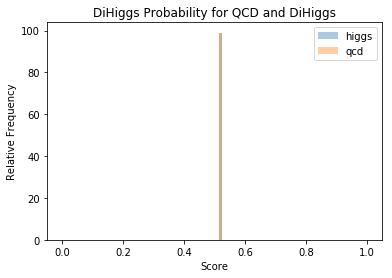

<Figure size 432x288 with 0 Axes>

In [10]:
print(sum(x < 0 for x in hh_pred).item(), "DiHiggs events with prob less than 0")
print(sum(x > 1 for x in hh_pred).item(), "DiHiggs events with prob greater than 1")
print(sum(y < 0 for y in qcd_pred).item(), "QCD events with prob less than 0")
print(sum(y > 1 for y in qcd_pred).item(), "QCD events with prob greater than 1")

plt.hist(hh_pred, bins=np.linspace(0, 1, 100), alpha=0.375, label="higgs", density=1)
plt.hist(qcd_pred, bins=np.linspace(0, 1, 100), alpha=0.375, label="qcd", density=1)
plt.legend()
plt.title("DiHiggs Probability for QCD and DiHiggs")
plt.xlabel("Score")
plt.ylabel("Relative Frequency")
plt.show()
plt.clf()


/Users/annacuddeback/LHCResearch/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


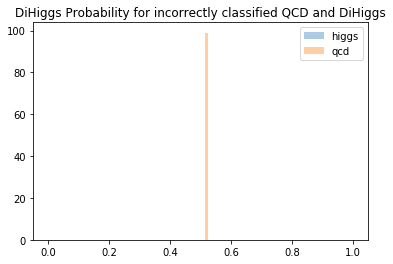

<Figure size 432x288 with 0 Axes>

In [11]:
plt.title("DiHiggs Probability for incorrectly classified QCD and DiHiggs")
plt.hist(hh_pred_wrong, bins=np.linspace(0, 1, 100), alpha=0.375, label="higgs", density=1)
plt.hist(qcd_pred_wrong, bins=np.linspace(0, 1, 100), alpha=0.375, label="qcd", density=1)
plt.legend()
plt.show()

plt.clf()

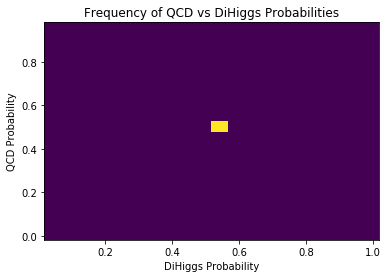

In [12]:
# my_cmap = plt.cm.jet
# my_cmap.set_under('w',1)

plt.hist2d(preds_h, preds_q, 20, label="Frequency")
plt.xlabel("DiHiggs Probability")
plt.ylabel("QCD Probability")
plt.title("Frequency of QCD vs DiHiggs Probabilities")
plt.show()